In [2]:
from __future__ import division
import sys, os
import numpy as np
import pandas as pd
from collections import OrderedDict
import pyfits

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.mlab as mlab
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Ellipse

In [3]:
modname      = 'sbpl+blackb'
version      = '-01-'
#version      = 'GBMwLAT_-01-'
#version      = 'GBM_-01-'
detector     = 'GBMwLAT'

burst       = 'bn080916009'

data_dir     = "/Users/derek/Documents/KimiZ/GRBs2/analysis/LAT/%s/integrated/"%burst
mod_dir      = "/Users/derek/Documents/KimiZ/GRBs2/analysis/LAT/%s/PYXSPEC/%s/%s/"%(burst, detector, modname)
desk_dir     = "/Users/derek/Desktop/kim/"
#mod_dir         = "/Users/KimiZ/GRBs2/analysis/LAT/%s/PYXSPEC/%s/%s/"%(burst, detector, modname)
#data_dir        = "/Users/KimiZ/GRBs2/analysis/LAT/%s/integrated/"%burst


fakedatafile    = os.path.join(data_dir, "fakeit_fitresults_%s_%s.fit"%(modname, version))
outfilename = "AfterFakeit_ParamDistPlots_%s_%s.pdf"%(modname, version)
outfile = os.path.join(mod_dir, outfilename)
outfile2 = os.path.join(desk_dir, outfilename)

paramoutfile = os.path.join(mod_dir, "AfterFakeit_ParamErrors_%s_%s.txt"%(modname, version))
paramoutfile2 = os.path.join(mod_dir, "AfterFakeit_ParamErrorsEASYREAD_%s_%s.txt"%(modname, version))

In [4]:
Fdata = pyfits.open(fakedatafile)

In [5]:
iter = 0
Bdata = pd.DataFrame()
for name in Fdata[1].data.columns.names:
    Bdata["%s"%name] = Fdata[1].data["%s"%name]
    if 'PARAM' in name:
        iter += 1
    else:
        pass
nPars = iter

In [6]:
Bdata = Bdata.astype('float64')

In [9]:
#pp = PdfPages(outfile)

In [7]:
def Plot_ParamComparison(modelname, ax, one, two):

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    
    XLabel = 'PARAM%i'%(one)
    YLabel = 'PARAM%i'%(two)

    x = Bdata["%s"%XLabel]
    y = Bdata["%s"%YLabel]
    muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
    muY, sigmaY = np.mean(y), np.sqrt(np.var(y))

    cov = np.cov(x, y)

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    for j in xrange(1, 4):
        width = 2 * j * np.sqrt(vals)[0]
        height = 2 * j * np.sqrt(vals)[1]
        ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width= width, height= height,
                      angle= theta)
        ell.set_facecolor('none')
        ax.add_artist(ell)

    plt.errorbar(np.mean(x), np.mean(y), xerr= 3*sigmaX, yerr= 3*sigmaY, color='green', lw=2)
    plt.errorbar(np.mean(x), np.mean(y), xerr= 2*sigmaX, yerr= 2*sigmaY, color='blue', lw=2)
    plt.errorbar(np.mean(x), np.mean(y), xerr= sigmaX, yerr= sigmaY, color='red', lw=2)
    plt.hexbin(x, y, bins='log', gridsize=40, cmap=plt.cm.Greys)#, alpha = 0.1)
    plt.xlim(x.min(), x.max())
    plt.ylim(y.min(), y.max())
    plt.xlabel("%s"%XLabel)
    plt.ylabel("%s"%YLabel)
    plt.title("%s"%modelname)


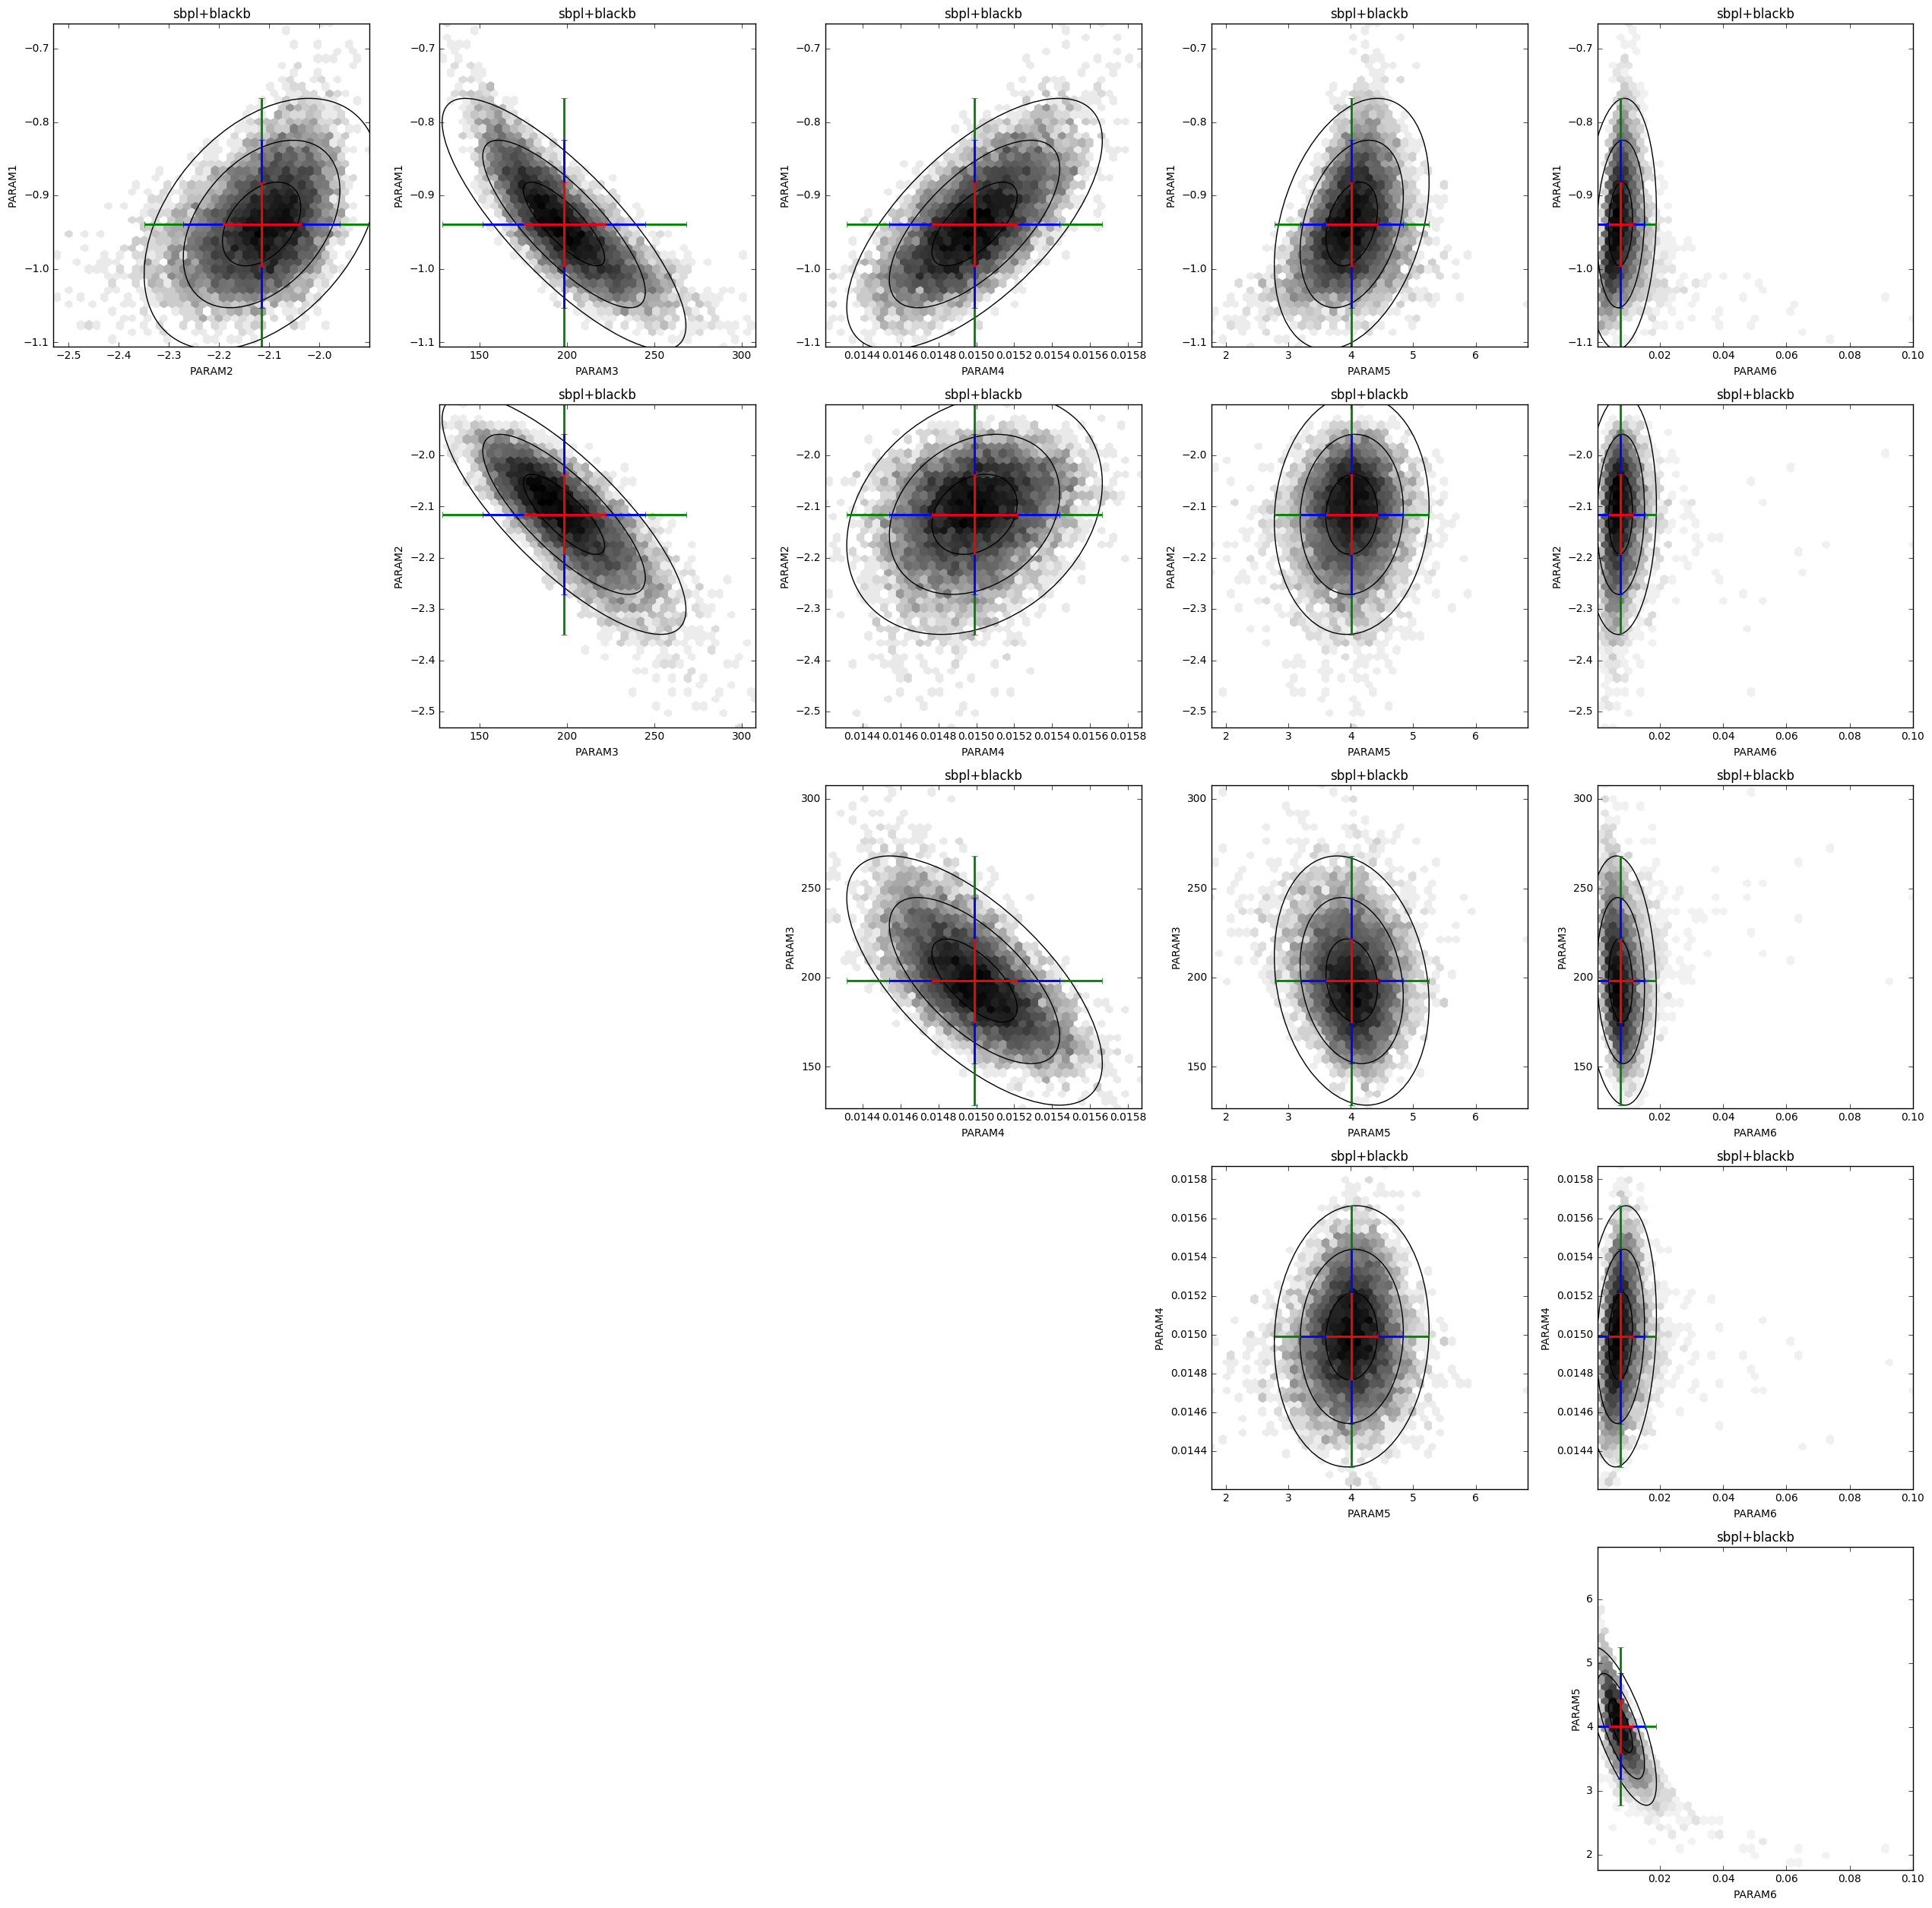

In [10]:
plt.figure(figsize=(5*nPars, 5*nPars))
for i in range(nPars):
    for j in range(i):
        ax = plt.subplot(nPars, nPars, nPars * (j + 1) + i + 1)
        Plot_ParamComparison(modname, ax, i+1, j+1)

plt.tight_layout()
#plt.savefig(pp2, format='pdf', dpi = 150, bbox_inches = 'tight')
#plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')


In [8]:
def Plot_ParamDistributions(modelname, parameter, Xlimits=None, bins=50):
    XLabel = str(parameter)

    x = Bdata["%s"%XLabel]
    mu, sigma = np.mean(x), np.sqrt(np.var(x))
    
    fig = plt.figure(figsize = (11,7))
    ax = fig.add_subplot(111)

    n, bins, patches = ax.hist(x, bins, normed=1, facecolor='green', alpha=0.75)
    bincenters = 0.5*(bins[1:]+bins[:-1])

    # add a 'best fit' line for the normal PDF
    y = mlab.normpdf(bincenters, mu, sigma)


    x1siglo = mu-sigma
    x1sighi = mu+sigma
    x2siglo = mu-2*sigma
    x2sighi = mu+2*sigma
    x3siglo = mu-3*sigma
    x3sighi = mu+3*sigma

    # ax.get_xlim()
    ylow, yhi = ax.get_ylim()
    ylabelpos = yhi - (yhi*.01)
    yhigh = yhi + (yhi*.1)
    #ylow, yhigh = ax.yaxis.get_data_interval()
    ax.vlines(mu, ylow, yhigh, linestyle='--', color="black") # mu + sigma
    ax.vlines(mu+sigma, ylow, yhigh, linestyle='--', color="black") # mu + sigma
    ax.vlines(mu-sigma, ylow, yhigh, linestyle='--', color="black") # mu - sigma
    ax.vlines(mu+2*sigma, ylow, yhigh, linestyle='--', color="black") # mu + 2*sigma
    ax.vlines(mu-2*sigma, ylow, yhigh, linestyle='--', color="black") # mu - 2*sigma
    ax.vlines(mu+3*sigma, ylow, yhigh, linestyle='--', color="black") # mu + 3*sigma
    ax.vlines(mu-3*sigma, ylow, yhigh, linestyle='--', color="black") # mu - 3*sigma
    #ax.text(x,y, "text")
    ax.text(mu, ylabelpos, r"$\mu$", fontsize = 12, horizontalalignment='center')
    ax.text(x1sighi, ylabelpos, r"$1\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x1siglo, ylabelpos, r"$1\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x2sighi, ylabelpos, r"$2\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x2siglo, ylabelpos, r"$2\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x3sighi, ylabelpos, r"$3\sigma$", fontsize = 12, horizontalalignment='center')
    ax.text(x3siglo, ylabelpos, r"$3\sigma$", fontsize = 12, horizontalalignment='center')
    ax.set_ylim(ylow, yhigh)
    
    ax.set_xlim(mu-5*sigma, mu+5*sigma)
    
    # if Xlimits is not None:
    #     ax.set_xlim(Xlimits)
    
    ax.plot(bincenters, y, 'r--', linewidth=1)
    ax.set_xlabel('%s'%XLabel)
    ax.set_title('%s'%modelname)


In [94]:
from scipy.stats import lognorm

In [378]:
lognorm.fit(Bdata["PARAM3"]) # 0.20080073031167195, 29.38409602369115, 497.47526983981265

(0.20080073031167195, 29.38409602369115, 497.47526983981265)

mu: 6.268002  sigma: 0.189419


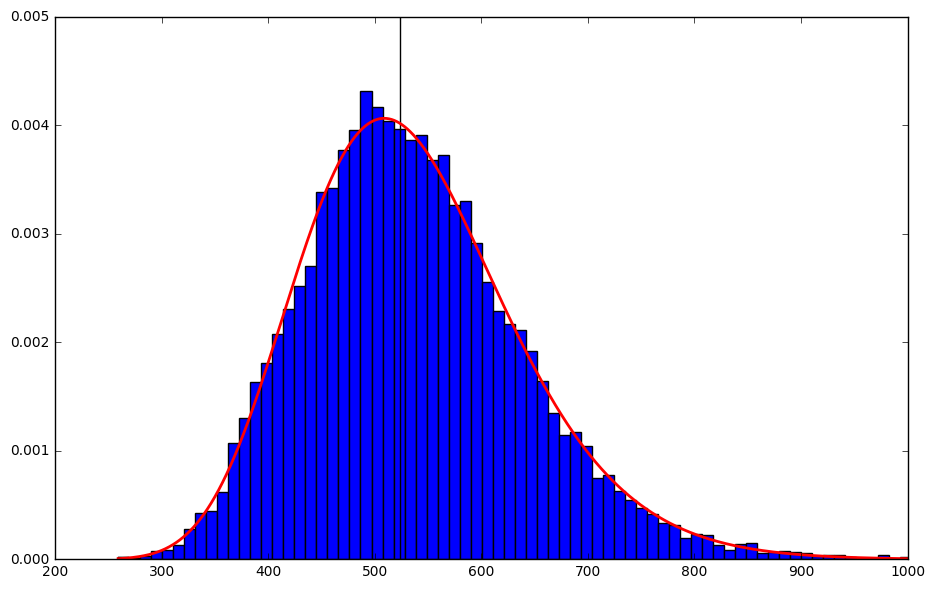

In [382]:
def lognormpdf(x, mu, sigma):
    return (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))


plt.figure(figsize=(11,7))
b = Bdata["PARAM3"]
count, bins, ignored = plt.hist(b, 100, normed=True, align='mid')

sigma = np.std(np.log(b))
mu = np.mean(np.log(b))

print "mu: %f  sigma: %f"%(mu, sigma)

x = np.linspace(min(bins), max(bins), 10000)
# pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, lognormpdf(x, mu, sigma), color='r', linewidth=2)

plt.vlines(524.111, 0, 0.005, colors='black')
plt.xlim(200,1000)
plt.show()

# lognorm.pdf doesn't have a mu parameter and therefore doesn't work.

lognorm.pdf(x, s) 

= 1 / (s\*x\*sqrt(2\*pi)) \* exp(-1/2\*(log(x)/s)^2)

pdf   
= (np.exp(-(np.log(x) - mu)^2 / (2 \* sigma^2)) / (x \* sigma \* np.sqrt(2 \* np.pi)))

In [432]:
data = Bdata["PARAM3"]

sigma  = np.std(np.log(data));    # sigma is shape
mu     = np.mean(np.log(data));   # mu is loc
scale  = np.exp(mu);              # scale
print "sigma: %f   mu: %f   scale: %f"%(sigma, mu, scale)

sigma: 0.189419   mu: 6.268002   scale: 527.422793


In [433]:
# lognorm.fit()  returns: shape(sigma), loc(mu), scale
sigma, mu, scale = lognorm.fit(data)
print "sigma: %f   mu: %f   scale: %f"%(sigma, mu, scale)

sigma: 0.200801   mu: 29.384096   scale: 497.475270


## Comparing the plots of the lognorm.fit(data) to using std, mean, and exp(mean) 
## to determine shape, loc, and scale.

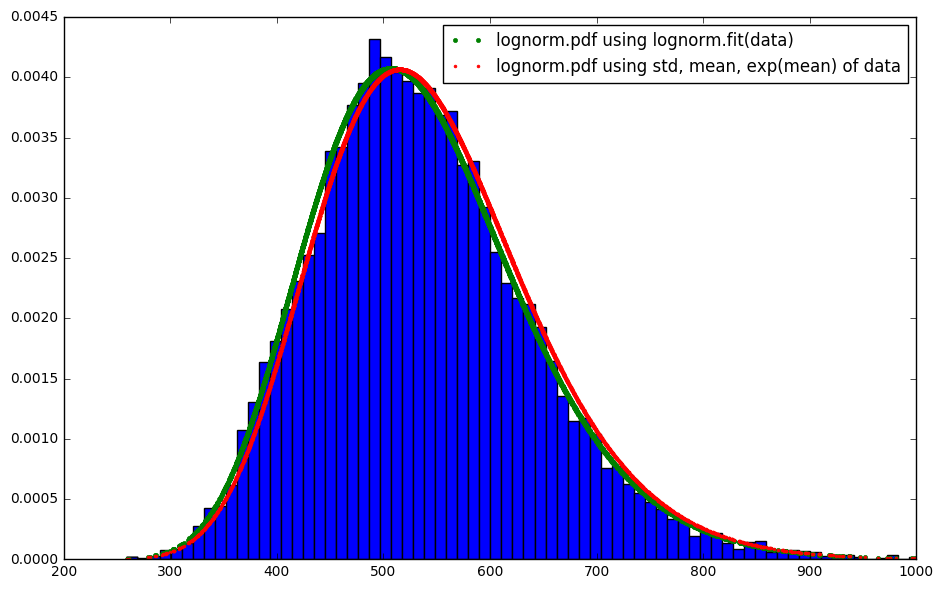

In [434]:
data = Bdata["PARAM3"]
plt.figure(figsize=(11,7))
count, bins, ignored = plt.hist(b, 100, normed=True, align='mid')

sigma, mu, scale = lognorm.fit(data)
x      = data
y_eqn  = (x - mu)
y      = lognorm.pdf(x, sigma, mu, scale)

plt.plot(x, y, 'g.', ms=6, label='lognorm.pdf using lognorm.fit(data)')


sigma   = np.std(np.log(data))
mu      = np.mean(np.log(data))
scale   = np.exp(mu);  

x      = data
y_eqn  = (x - mu)
y      = lognorm.pdf(x, sigma, mu, scale)

plt.plot(x, y, 'r.', ms=4, label='lognorm.pdf using std, mean, exp(mean) of data')

plt.xlim(200,1000)
plt.legend(loc='best')
plt.show()

mu: 6.268002  sigma: 0.189419  scale: 527.422793
P(0.025)= 370.120609   P(.5)= 533.690796    P(.975)= 770.794072


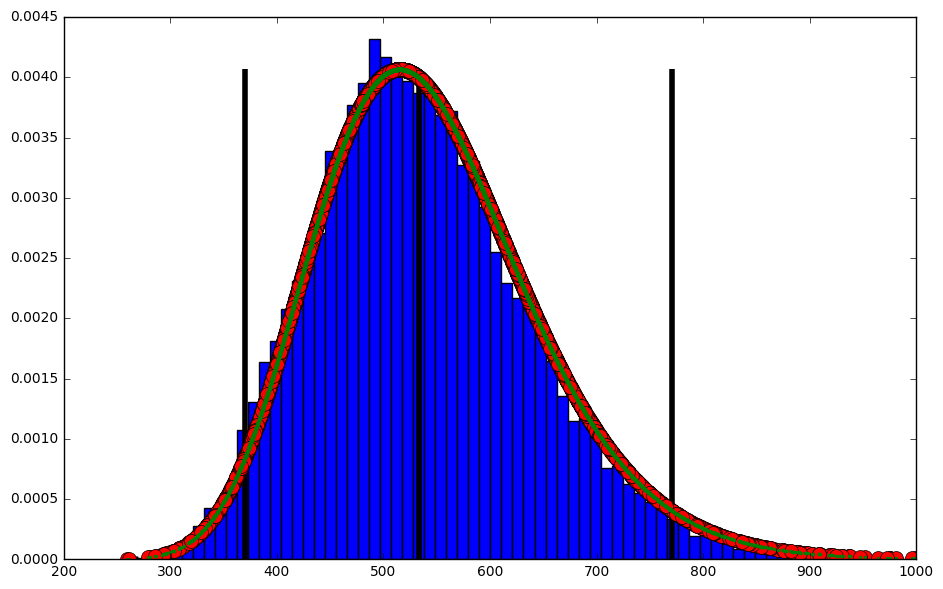

In [419]:
data = Bdata["PARAM3"]
plt.figure(figsize=(11,7))
count, bins, ignored = plt.hist(b, 100, normed=True, align='mid')

sigma   = np.std(np.log(data))
mu      = np.mean(np.log(data))
scale   = np.exp(mu);  
print "mu: %f  sigma: %f  scale: %f"%(mu, sigma, scale)

x      = data
y_eqn  = (x - mu)/scale
y      = lognorm.pdf(y_eqn, sigma)/scale
plt.plot(x, y, 'ro', ms=10)

x      = data
y_eqn  = (x - mu)
y      = lognorm.pdf(x, sigma, mu, scale)

plt.plot(x, y, 'g.', ms=4)

vals = lognorm.ppf([0.025, 0.5, 0.975], s=sigma, loc=mu, scale=scale)
print "P(0.025)= %f   P(.5)= %f    P(.975)= %f"%(vals[0], vals[1], vals[2])

plt.vlines(vals, y.min(), y.max(), colors='black', lw=4)
plt.xlim(200,1000)
plt.show()

In [ ]:
def lognorm_mean():
    return 

In [444]:
sigma, mu, scale

(0.18941859947654069, 6.2680024912611554, 527.42279331868428)

In [466]:
# no mode in numpy
np.mean(data), np.median(data), np.var(data)

(536.99933128312739, 527.23200574616567, 10652.347973994305)

In [461]:
data.mean(), data.median(), data.mode(), data.var()

(536.99933128312739,
 527.2320057461657,
 Series([], dtype: float64),
 10653.413315325837)

In [460]:
# mean, median, mode, variance
np.exp(mu+(sigma**2)/2.), np.exp(mu), np.exp(mu-(sigma**2)), (np.exp(sigma**2)-1)*np.exp(2*mu+sigma**2)

(536.96998235971103,
 527.42279331868428,
 508.83463692869492,
 10533.183936849424)

In [484]:
lognorm.mean(sigma, mu, scale), lognorm.median(sigma, mu, scale), lognorm.var(sigma, mu, scale)

(543.23798485097234, 533.69079580994548, 10533.183936849427)

In [489]:
lognorm.mean(sigma, mu, scale), lognorm.median(sigma, mu, scale), lognorm.var(sigma, mu, scale)

(543.23798485097234, 533.69079580994548, 10533.183936849427)

In [ ]:
# mean
plt.vlines(524.111, 0, 0.005, colors='blue')

# 1 sigma
plt.vlines(443.6638, 0, 0.005, colors='blue')
plt.vlines(620.48059, 0, 0.005, colors='blue')

# 2 sigma
plt.vlines(375.74341, 0, 0.005, colors='blue')
plt.vlines(735.930723, 0, 0.005, colors='blue')

In [435]:
vals = lognorm.ppf([0.025, 0.5, 0.975], s=sigma, loc=mu, scale=scale)
vals

array([ 370.12060894,  533.69079581,  770.79407152])

In [439]:
lognorm.ppf([0.34, 0.5, 0.65], s=sigma, loc=mu, scale=scale)

array([ 494.05279174,  533.69079581,  573.62535376])

mu: 6.268002  sigma: 0.189419


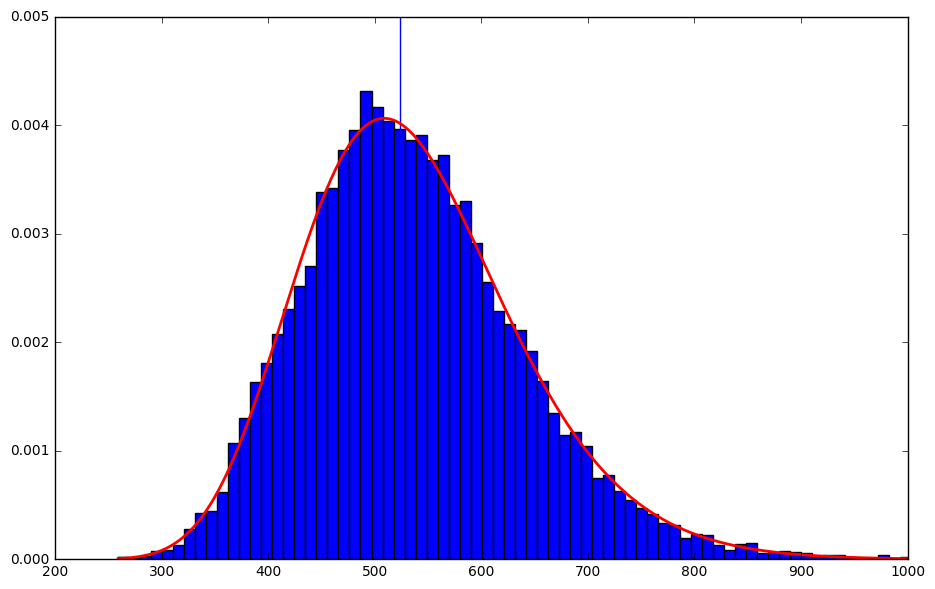

In [436]:
# Generate a thousand samples: each is the product of 100 random
# values, drawn from a normal distribution.
# b = []
# for i in range(1000):
#     a = 10. + np.random.random(100)
#     b.append(np.product(a))

#b = np.array(b) / np.min(b) # scale values to be positive
plt.figure(figsize=(11,7))
b = Bdata["PARAM3"]
count, bins, ignored = plt.hist(b, 100, normed=True, align='mid')
sigma = np.std(np.log(b))
mu = np.mean(np.log(b))
print "mu: %f  sigma: %f"%(mu, sigma)

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, color='r', linewidth=2)

plt.vlines(524.111, 0, 0.005, colors='blue')
plt.xlim(200,1000)
plt.show()

In [318]:
lognorm.ppf([0.025], pdf)

array([ 0.99998598,  0.99998587,  0.99998577, ...,  0.99999996,
        0.99999996,  0.99999996])

In [325]:
vals = lognorm.ppf([0.001, 0.5, 0.999], b.mean())

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:3188: RuntimeWarning: overflow encountered in exp
  return exp(s * _norm_ppf(q))


In [326]:
vals

array([  0.,   1.,  inf])

(200, 1000)

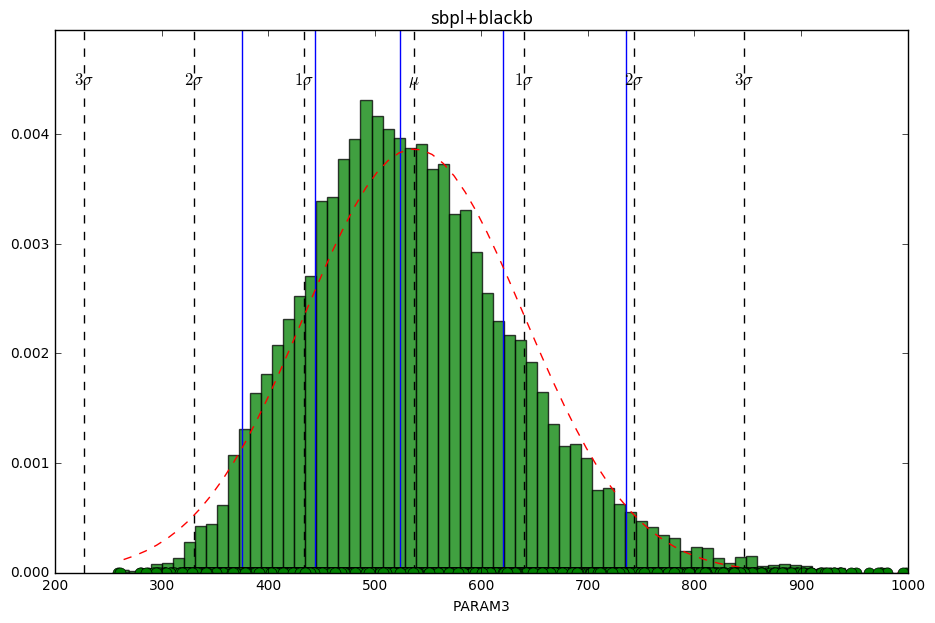

In [156]:
xA = Bdata["PARAM3"]
muA = Bdata["PARAM3"].mean()
Plot_ParamDistributions(modname, 'PARAM3', bins=100)
plt.plot(xA, poisson.pmf(xA, muA), 'go', ms=8, label='poisson pmf')
plt.vlines(524.111, 0, 0.005, colors='blue')
plt.vlines(443.6638, 0, 0.005, colors='blue')
plt.vlines(620.48059, 0, 0.005, colors='blue')
plt.vlines(375.74341, 0, 0.005, colors='blue')
plt.vlines(735.930723, 0, 0.005, colors='blue')
plt.xlim(200,1000)

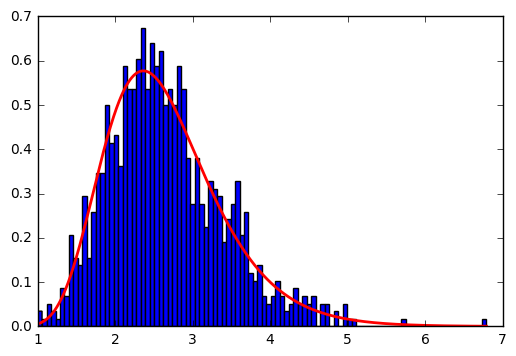

In [147]:
# Generate a thousand samples: each is the product of 100 random
# values, drawn from a normal distribution.
b = []
for i in range(1000):
    a = 10. + np.random.random(100)
    b.append(np.product(a))

b = np.array(b) / np.min(b) # scale values to be positive
count, bins, ignored = plt.hist(b, 100, normed=True, align='mid')
sigma = np.std(np.log(b))
mu = np.mean(np.log(b))

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, color='r', linewidth=2)
plt.show()

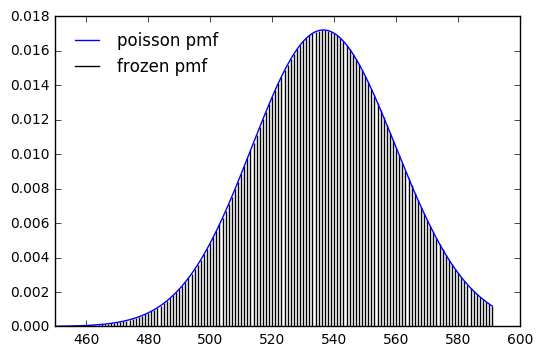

In [83]:
fig, ax = plt.subplots(1, 1)
mu = Bdata["PARAM3"].mean() 

mean, var, skew, kurt = poisson.stats(mu, moments='mvsk') # mean is same as mu

x = np.arange(poisson.ppf(0.99, mu))#, poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'b-', label='poisson pmf')
ax.set_xlim([450,600])
#ax.vlines(x, 0, poisson.pmf(x, mu), colors='b', lw=5, alpha=0.5)

rv = poisson(mu)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1, label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

In [90]:
var

array(536.9993312831274)

(200, 1000)

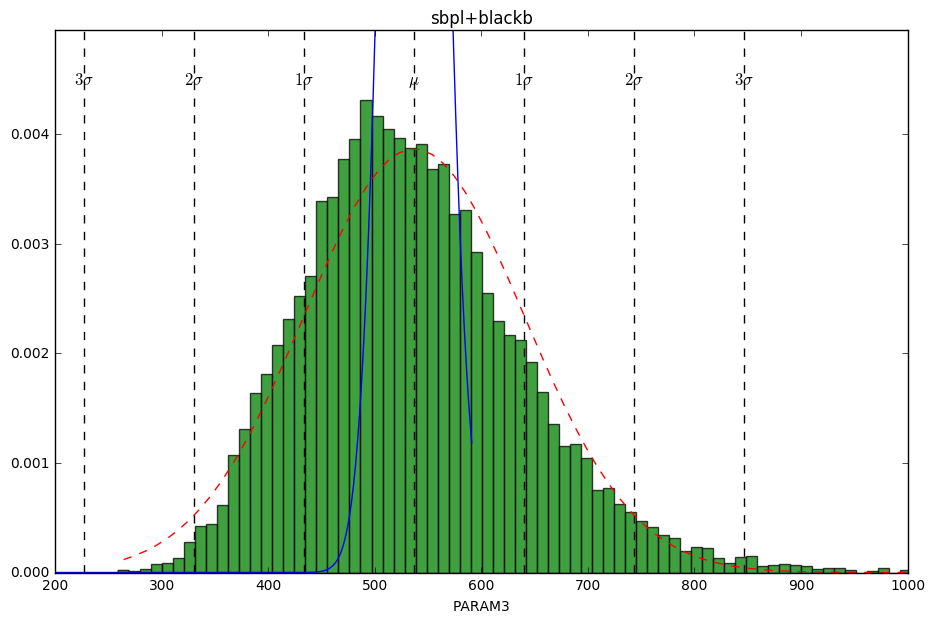

In [93]:
#fig, ax = plt.subplots(1, 1)
mu = Bdata["PARAM3"].mean() 

mean, var, skew, kurt = poisson.stats(mu, moments='mvsk') # mean is same as mu

x = np.arange(poisson.ppf(0.99, mu))#, poisson.ppf(0.99, mu))
#x = np.arange(poisson.ppf(0.99, mu))#, poisson.ppf(0.99, mu))
Plot_ParamDistributions(modname, 'PARAM3', bins=100)
plt.plot(x, poisson.pmf(x, mu), 'b-', label='poisson pmf')
plt.xlim([200,1000])
#Plot_ParamDistributions(modname, 'PARAM3', bins=100)

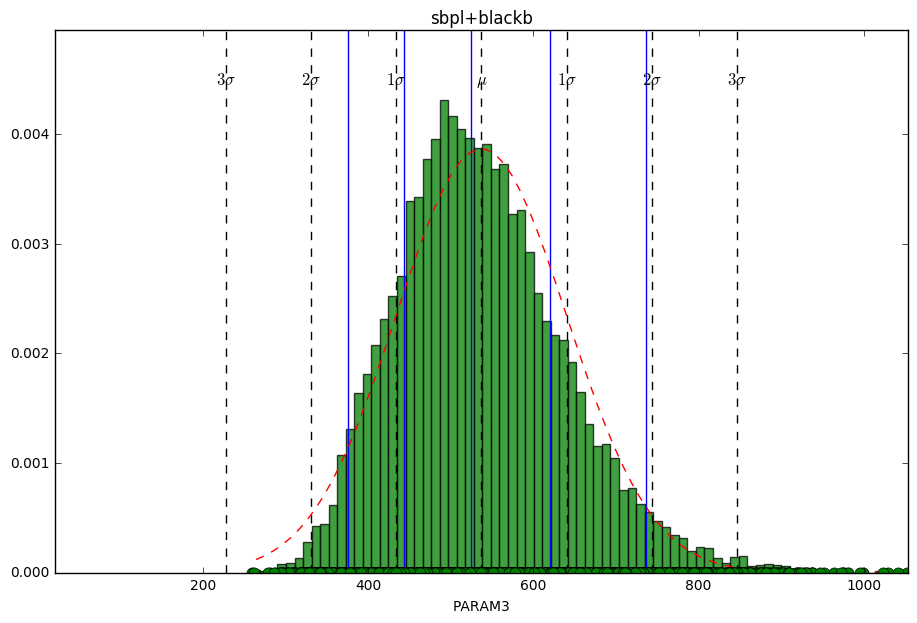

In [36]:
xA = Bdata["PARAM3"]
muA = Bdata["PARAM3"].mean()
Plot_ParamDistributions(modname, 'PARAM3', bins=100)
plt.plot(xA, poisson.pmf(xA, muA), 'go', ms=8, label='poisson pmf')
plt.vlines(524.111, 0, 0.005, colors='blue')
plt.vlines(443.6638, 0, 0.005, colors='blue')
plt.vlines(620.48059, 0, 0.005, colors='blue')
plt.vlines(375.74341, 0, 0.005, colors='blue')
plt.vlines(735.930723, 0, 0.005, colors='blue')

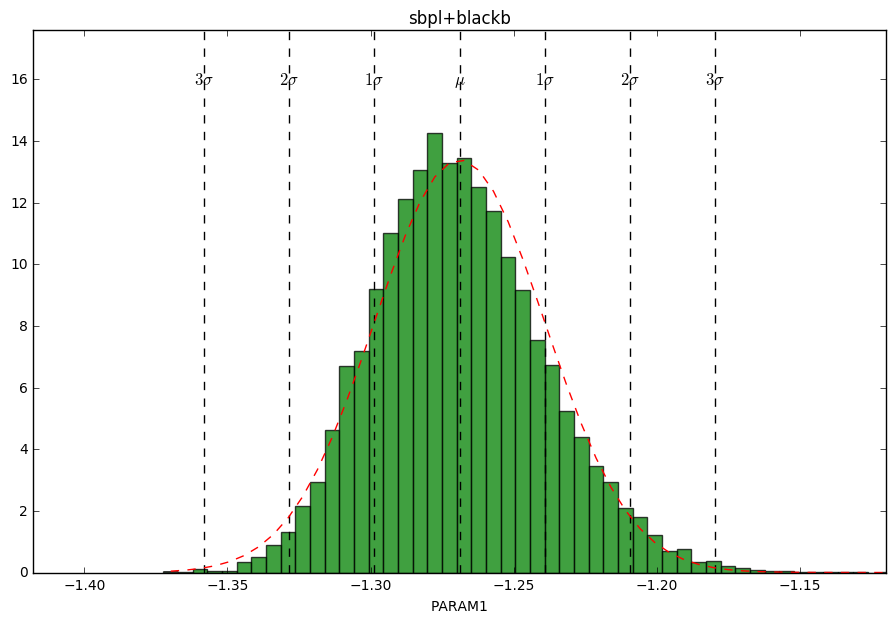

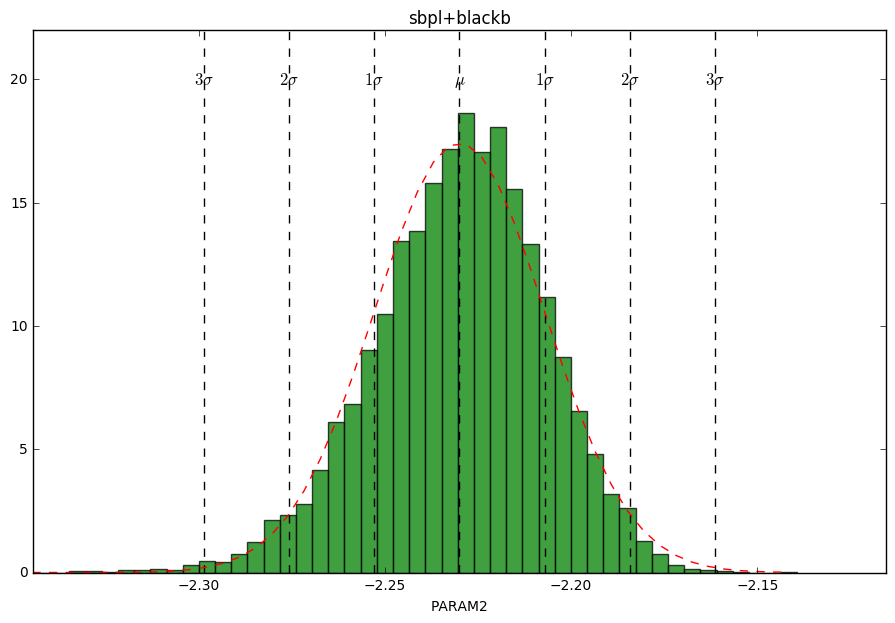

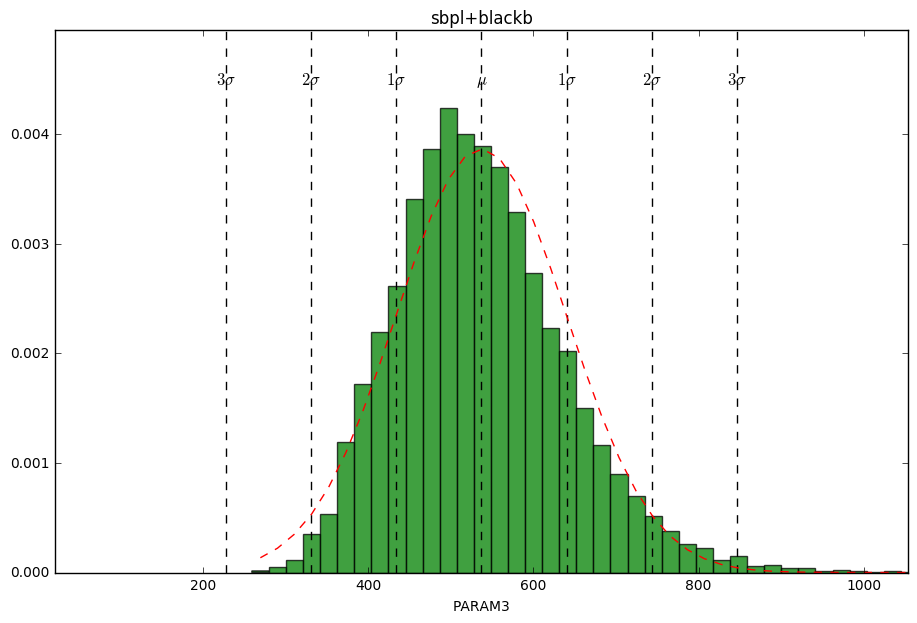

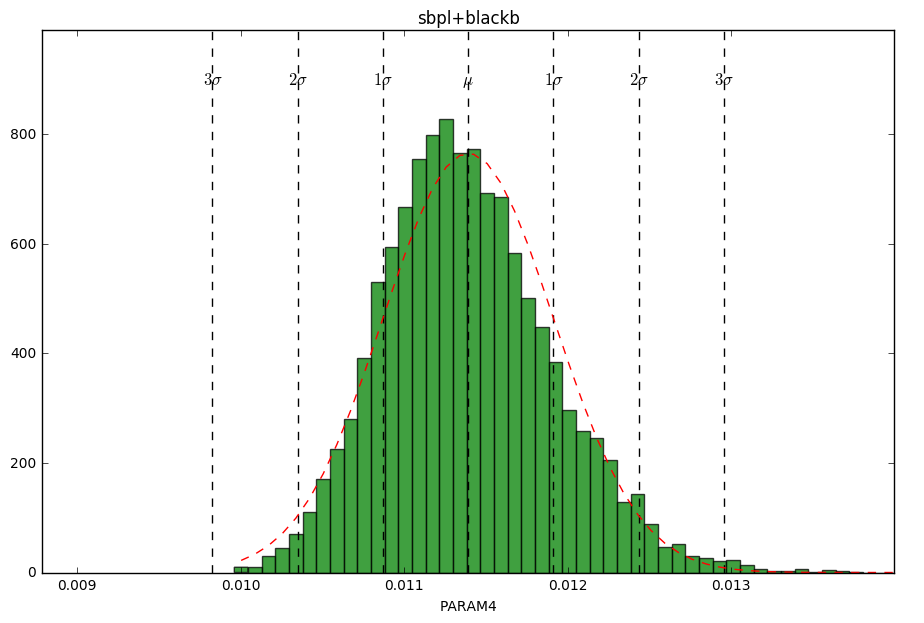

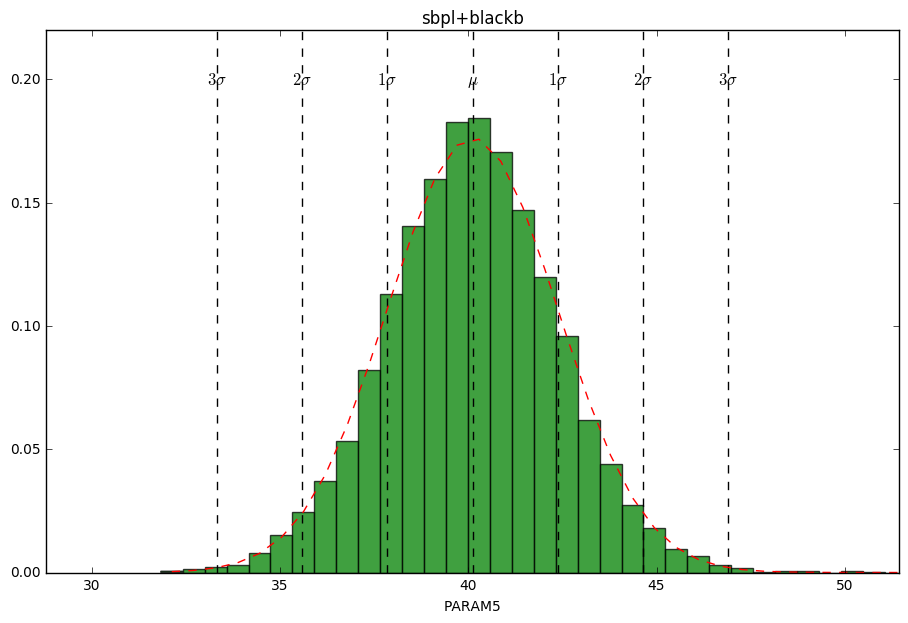

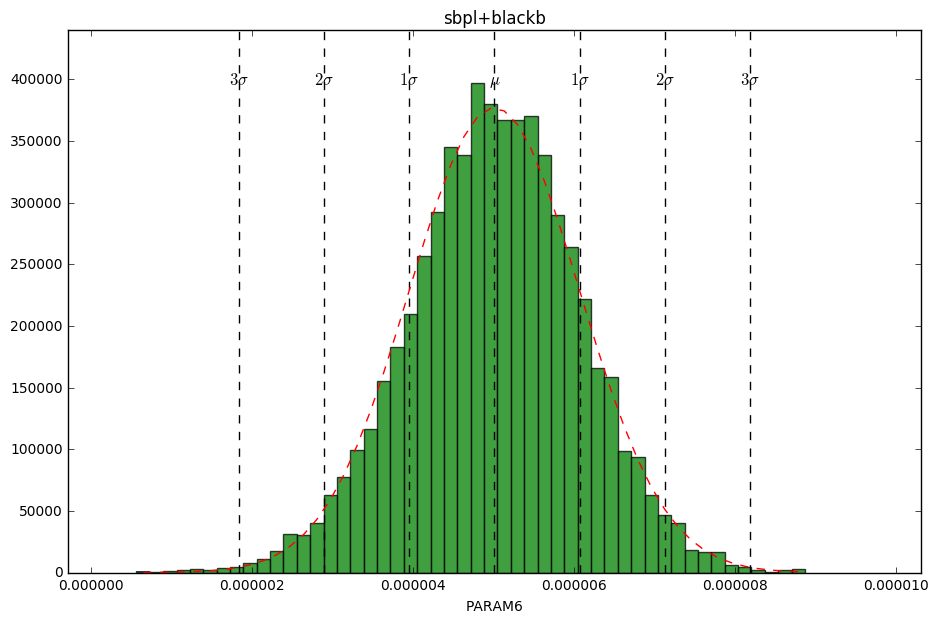

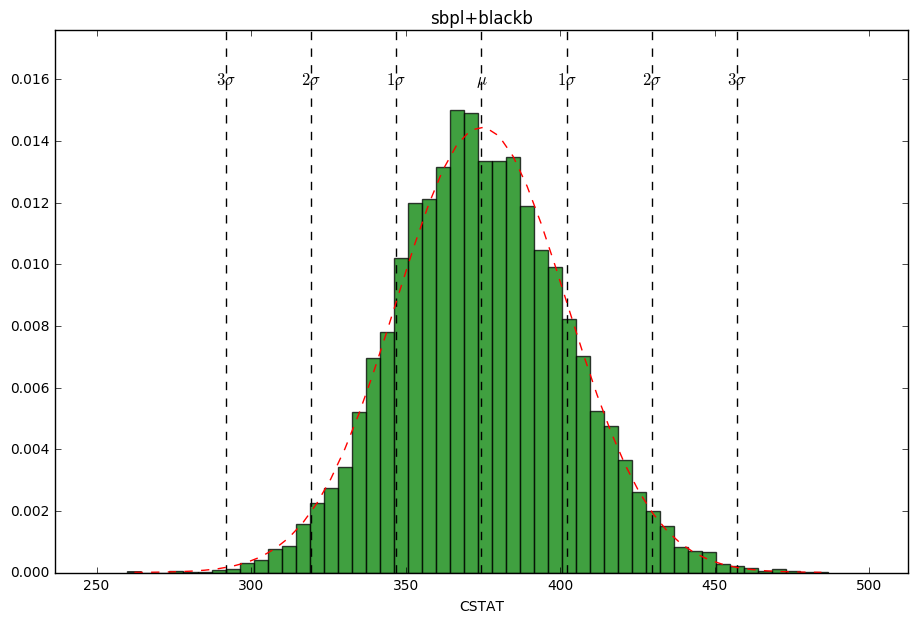

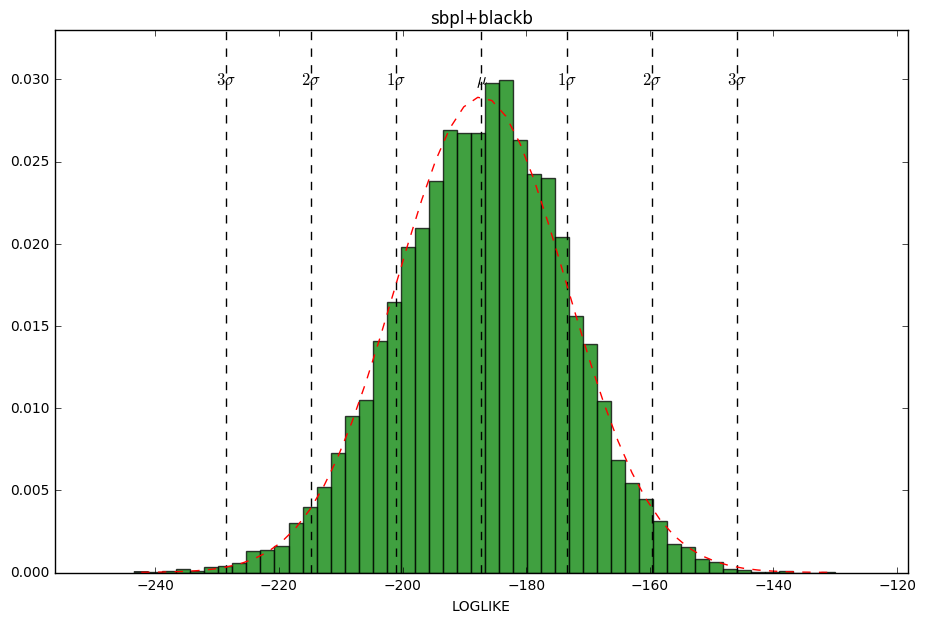

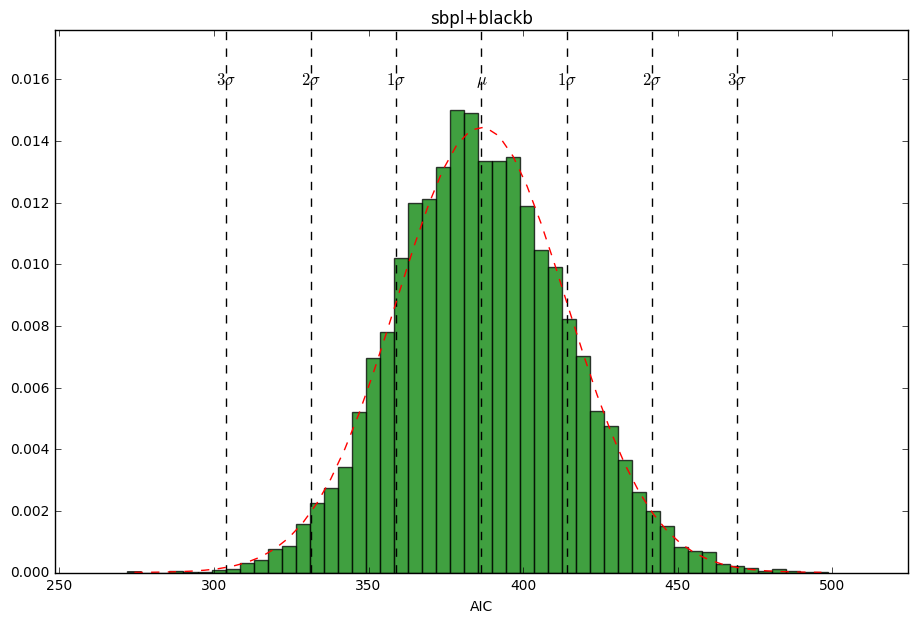

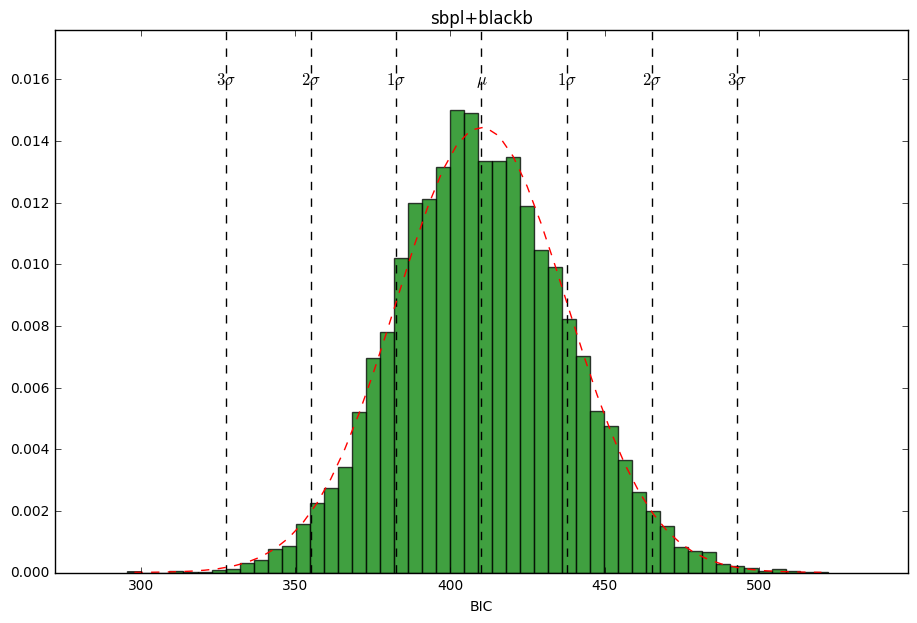

In [9]:
for name in Bdata.columns:
    if 'PARAM' in name:
        Plot_ParamDistributions(modname, name)
        #plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        Plot_ParamDistributions(modname, name)
        #plt.savefig(pp, format='pdf', dpi=150, bbox_inches = 'tight')
    else:
        pass

In [13]:
#pp.close()

In [14]:
target = open(paramoutfile2, 'w')

In [15]:
for name in Bdata.columns:
    if 'PARAM' in name:
        x = Bdata["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        line1 =  "%s"%name
        line2 = "Value:    %.13f"%muX
        line3 = "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        line4 = "2-sigma:  %.13f, %.13f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        line5 = "3-sigma:  %.13f, %.13f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        line6 = "min max:  %.13f, %.13f"%(x.min(), x.max())
        #print ""
        target.write(line1)
        target.write("\n")
        target.write(line2)
        target.write("\n")
        target.write(line3)
        target.write("\n")
        target.write(line4)
        target.write("\n")
        target.write(line5)
        target.write("\n")
        target.write(line6)
        target.write("\n")
        target.write("\n")
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        x = Bdata["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        line1 =  "%s"%name
        line2 = "Value:    %.13f"%muX
        line3 = "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        line4 = "2-sigma:  %.13f, %.13f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        line5 = "3-sigma:  %.13f, %.13f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        line6 = "min max:  %.13f, %.13f"%(x.min(), x.max())
        #print ""
        target.write(line1)
        target.write("\n")
        target.write(line2)
        target.write("\n")
        target.write(line3)
        target.write("\n")
        target.write(line4)
        target.write("\n")
        target.write(line5)
        target.write("\n")
        target.write(line6)
        target.write("\n")
        target.write("\n")
    else:
        pass

In [16]:
target.close()

In [17]:
param_dict = OrderedDict()
for name in Bdata.columns:
    if 'PARAM' in name:
        x = Bdata["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        # print "%s"%name
        # print "Value:    %.13f"%muX
        # print "1-sigma:  %.13f, %.13f"%(muX - sigmaX, muX + sigmaX)
        # print "2-sigma:  %.10f, %.10f"%(muX - 2*sigmaX, muX + 2*sigmaX)
        # print "3-sigma:  %.10f, %.10f"%(muX - 3*sigmaX, muX + 3*sigmaX)
        # print ""
        param_dict["%s"%name] = [muX, muX - sigmaX, muX + sigmaX, muX - 2*sigmaX, muX + 2*sigmaX, muX - 3*sigmaX, muX + 3*sigmaX, x.min(), x.max()]
    elif ('AIC' in name) or ('BIC' in name) or ('LOGLIKE' in name) or ('CSTAT' in name):
        x = Bdata["%s"%name]
        muX, sigmaX = np.mean(x), np.sqrt(np.var(x))
        param_dict["%s"%name] = [muX, muX - sigmaX, muX + sigmaX, muX - 2*sigmaX, muX + 2*sigmaX, muX - 3*sigmaX, muX + 3*sigmaX, x.min(), x.max()]
    else:
        pass
        

In [18]:
outDataFrame = pd.DataFrame(param_dict)

In [19]:
outDataFrame.to_csv(path_or_buf = paramoutfile, sep = ',', header=True, index=False)

In [20]:
os.system('cp %s %s'%(outfile, outfile2))

0